# DiploDatos 2021


### Categorización de publicaciones de productos realizadas en Mercado Libre

### 04 - Aprendizaje Supervisado

#### Condiciones generales que aplican a todos los prácticos:

- Las notebooks tienen que ser 100% reproducibles, es decir al ejecutar las celdas tal cuál como se entrega la notebook se deben obtener los mismos resultados sin errores.
- Código legible, haciendo buen uso de las celdas de la notebook y en lo posible seguir estándares de código para *Python* (https://www.python.org/dev/peps/pep-0008/).
- Utilizar celdas tipo *Markdown* para ir guiando el análisis.
- Limpiar el output de las celdas antes de entregar el notebook (ir a `Kernel` --> `Restart Kernel and Clear All Ouputs`).
- Incluir conclusiones del análisis que se hizo en la sección "Conclusiones". Tratar de aportar valor en esta sección, ser creativo.

## 1. Consignas

El objetivo de este **TP** es iterar sobre el modelado, experimentando con distintas técnicas, y utilizar el *pipeline* de datos que se realizó en el **TP** pasado.

#### Sección 1: Modelado

- Implementar redes del tipo *feed foward* y *LSTM*.

#### Sección 2: Regularización

El objetivo de este bloque es experimentar con distintos métodos de regularización.
A continuación se deja una lista de distinas técnicas.
Investigar de qué se trata cada una e implementarlas.
Tener en cuenta que no es necesario implementar todo lo que se propone.

- Experimentar con distintos tamaños de modelo. Sacar / agregar capas como así también neuronas.

- Utilizar distinos valores de *batch size*.

- Experimentar utilizando *dropout* y *batch normalization*. (**HECHO** en **TP** pasado)

- Experimentar con distintos valores para el *learning rate*.

- Experimentar con técnicas de *weight decay* y *early stopping*.

#### Sección 3: Ajuste de Hiperparámetros

Este bloque es **opcional**, ya que puede ser complejo hacer la implementación en redes neuronales.

- Investigar, y en lo posible implemementar, alguna técnica de búsqueda de hiperparámetros como *Grid Search* o *Random Search*.

#### Sección 4: Documentación de Resultados

- Dejar documentado de algún lado (puede ser en un documento de texto aparte) los resultados de toda la experimentación de este **TP**. Es importante que queden claros los resultados de las métricas de cada modelo, cual de todos los modelos entrenados fue el superador, y una breve descripción del mismo.

## 2. Código y análisis

Instalaciones necesarias.

In [1]:
!pip install Unidecode
!pip install keras-tuner

Importaciones necesarias

In [2]:
import pandas as pd
import numpy as np

Lectura de dataset reducido

In [3]:
df_dataset = pd.read_csv('DataSet/dataset.csv')

Estudiamos el dataset brevemente antes de comenzar a operar sobre el mismo.

In [4]:
df_dataset.describe()

,title,label_quality,language,category
count,646760,646760,646760,646760
unique,646019,2,2,20
top,Korg Kronos X 73,unreliable,portuguese,PANTS
freq,2,551878,328992,35973


In [5]:
classes = np.sort(df_dataset.category.unique())

print(f'Dimensiones: {df_dataset.shape}')
print('----------')
print(f'Variables: {list(df_dataset.columns)}')
print('----------')
print(f'Categorías: {list(classes)}')

Dimensiones: (646760, 4)
----------
Variables: ['title', 'label_quality', 'language', 'category']
----------
Categorías: ['BABY_CAR_SEATS', 'BABY_STROLLERS', 'COFFEE_MAKERS', 'ELECTRIC_DRILLS', 'HAIR_CLIPPERS', 'KITCHEN_SINKS', 'MATTRESSES', 'MEMORY_CARDS', 'MOTORCYCLE_JACKETS', 'MUSICAL_KEYBOARDS', 'PANTS', 'PUREBRED_DOGS', 'RANGES', 'REFRIGERATORS', 'ROLLER_SKATES', 'SEWING_MACHINES', 'SHORTS', 'SUITCASES', 'WALL_CLOCKS', 'WINES']


**Sección 0**
Preparando el conjunto de datos.

In [6]:
from scripts.utils import cleaning

df_dataset['clean_title'] = df_dataset.title.apply(cleaning)

In [7]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_dataset, train_size=0.8, test_size=0.2, random_state=123)

print(f'Dimensiones Entrenamiento: {df_train.shape}')
print(f'Dimensiones Evaluación: {df_test.shape}')

Dimensiones Entrenamiento: (517408, 5)
Dimensiones Evaluación: (129352, 5)


In [8]:
# Datos de Entrenamiento
X_train = df_train.clean_title.values
y_train = df_train.category.values
# Datos de Test
X_test = df_test.clean_title.values
y_test = df_test.category.values

**Sección 0**
Procesando el conjunto de datos.

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

word_tokenizer = Tokenizer()
# Aprendemos el Tokenizer en base a los datos de entrenamiento.
word_tokenizer.fit_on_texts(X_train)
# Longitud del Vocabulario en base a los datos de entrenamiento.
vocab_length = len(word_tokenizer.word_index) + 1

embedded_sentences_train = word_tokenizer.texts_to_sequences(X_train)
embedded_sentences_test = word_tokenizer.texts_to_sequences(X_test)

padded_sentences_train = pad_sequences(embedded_sentences_train, padding='post')
# Longitud de Sentencias en base a los datos de entrenamiento.
ammount_sentences, sentences_length = padded_sentences_train.shape

padded_sentences_test = pad_sequences(embedded_sentences_test, padding='post', maxlen=sentences_length)

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(classes)

encoded_labels_train = le.transform(y_train)
encoded_labels_test = le.transform(y_test)

In [11]:
from keras.layers.embeddings import Embedding

dense_vector_size = 30
embedding_layer = Embedding(vocab_length, dense_vector_size, input_length=sentences_length)

**Observación**

Solo trabajaremos con *custom embeddings* por dificultades encontradas al adaptar el modelo a los *word vectors* preentrenados de **fastText**.
Una tarea que quedará pendiente, será replantear el uso de esta herramienta.

**Sección 1**
Modelado

In [12]:
from scripts.models import NN_Baseline, NN_LSTM, NN_Baseline_Regularized, NN_LSTM_Regularized

m1 = NN_Baseline(embedding_layer, classes)
m2 = NN_LSTM(embedding_layer, classes)
m3 = NN_Baseline_Regularized(embedding_layer, classes)
m4 = NN_LSTM_Regularized(embedding_layer, classes)

models = {}
stops = {}
# Compilamos nuestros modelos.
for m in [m1, m2, m3, m4]:
  m.model_compile()
  # Almacenamos el modelo correspondiente.
  models[m.name] = m.model
  # Almacenamos la opción de Early Stopping.
  stops[m.name] = m.model_allow_stop()

Se trabajará con cuatro modelos diferentes.

- `Baseline` Consiste simplemente de capas densas, con función de activación sigmoide.
- `Baseline Regularized` Se aplican técnicas de regularización sobre el modelo original. Utilizamos *weight decay* sobre las capas densas, y se permite *early stopping* en su entrenamiento.
- `LSTM` Consiste de capas densas, con función de activación sigmoide, junto con una capa *lstm*.
- `LSTM Regularized` Se aplican técnicas de regularización sobre el modelo original. Utilizamos *weight decay* sobre las capas densas y la capa *lstm*, y se permite *early stopping* en su entrenamiento.

**Sección 2**
Regularización

En base a la lista de técnicas que tenemos disponible, realizamos una breve investigación de cada una antes de comenzar con su implementación.
A continuación mencionamos algunas de sus características relevantes.

- **Experimentar con los tamaños del modelo**

La idea es modificar la arquitectura de la red.
Nuestro modelo `Baseline`, por dar un ejemplo, tiene **2** capas ocultas densas, con **256** y **128** neuronas respectivamente.
Es una arquitectura definida totalmente de manera arbitraria, y sin ningún fundamento para respaldarla.
Durante la experimentación podríamos modificar la cantidad de capas ocultas y/o la cantidad de neuronas en cada una.
Quizás reduciendo alguna de estas cantidades podríamos regularizar el aprendizaje y evitar el *overfitting* observado en el **TP** anterior.

- **Distinos valores de *batch size***

El *batch size* determina la cantidad de muestras que serán propagadas por la red (en una iteración de *forward pass* y *backward pass*).
Utilizar un tamaño **pequeño** reduce el uso de memoria, y generalmente acelera el entrenamiento al actualizar los pesos luego de cada propagación.
Utilizar un tamaño **grande** mejora la precisión de la estimación del gradiente, al observar una mayor cantidad de datos de entrenamiento se puede realizar una actualización más certera de los pesos de la red.

- **Utilizar *dropout* y *batch normalization***

**Dropout** es una técnica donde ciertas neuronas seleccionadas aleatoriamente son ignoradas durante el entrenamiento.
Lo cual significa que no contribuirán en la activación de neuronas durante el *forward pass*, y no se le aplicará ninguna actualización de pesos durante el *backward pass*.
El objetivo es que la red sea menos sensible a los pesos específicos de las neuronas, y que sea capaz de generalizar mejor.

**Batch Normalization** es una capa para normalizar la muestra que recibe.
Aplica una transformación que mantiene la *media* cercana a **0**, y su *desviación estándar* cercana a **1**.
El objetivo es evitar que ciertas características de los datos dominen el entrenamiento de la red neuronal por sobre las demás.

- **Distintos valores de *learning rate***

Una red neuronal es entrenada utilizando el algoritmo de optimización **Descenso de Gradiente Estocástico** (*SGD*).
El *learning rate* es el hiperparámetro que controla cuanto cambiará el modelo en respuesta al error estimado cada vez que los pesos de la red son actualizados.
Una tasa de aprendizaje **pequeña** podría resultar en un entrenamiento largo, el cual puede no converger.
Una tasa de aprendizaje **grande** podría aprender un conjunto de pesos subóptimos, con un entrenamiento inestable.

- **Utilizar *weight decay* y *early stopping***

**Weight Decay** es una técnica de regularización utilizada en redes neuronales.
La idea consiste en agregar un término a la pérdida, el cual sea proporcional a la magnitud de los pesos de la red.
De esta manera, durante el proceso de entrenamiento, se intentaría decrementar el valor de los pesos.

**Early Stopping** es un método que permite detener el entrenamiento una vez que la red neuronal deja de mejorar su rendimiento.
El problema que se intenta solucionar es la elección del número de épocas de entrenamiento.
Una cantidad de *epochs* demasiado **grande** puede producir *overfitting*.
Una cantidad de *epochs* demasiado **pequeña** puede producir *underfitting*.

In [13]:
from scripts.train import train

training = {}
for name, model in models.items():
  print(f'{name}:')
  history = train(name, model, padded_sentences_train, encoded_labels_train, allow_stop=stops[name])
  training[name] = history

NN_Baseline:
Epoch 1/10
12936/12936 [==============================] - 120s 9ms/step - loss: 0.2471 - accuracy: 0.9308 - val_loss: 0.0631 - val_accuracy: 0.9841
Epoch 2/10
12936/12936 [==============================] - 116s 9ms/step - loss: 0.0447 - accuracy: 0.9883 - val_loss: 0.0613 - val_accuracy: 0.9850
Epoch 3/10
12936/12936 [==============================] - 116s 9ms/step - loss: 0.0285 - accuracy: 0.9925 - val_loss: 0.0611 - val_accuracy: 0.9862
Epoch 4/10
12936/12936 [==============================] - 116s 9ms/step - loss: 0.0206 - accuracy: 0.9948 - val_loss: 0.0650 - val_accuracy: 0.9860
Epoch 5/10
12936/12936 [==============================] - 115s 9ms/step - loss: 0.0161 - accuracy: 0.9958 - val_loss: 0.0705 - val_accuracy: 0.9857
Epoch 6/10
12936/12936 [==============================] - 115s 9ms/step - loss: 0.0137 - accuracy: 0.9964 - val_loss: 0.0746 - val_accuracy: 0.9859
Epoch 7/10
12936/12936 [==============================] - 116s 9ms/step - loss: 0.0116 - accuracy: 

Con esto ya hemos entrenado nuestros cuatro modelos, tanto los originales (`Baseline` y `LSTM`) como sus versiones regularizadas (`Baseline Regularized` y `LSTM Regularized`).

Notar que solo estamos experimentando con *weight decay* y *early stopping* como técnicas de regularización.

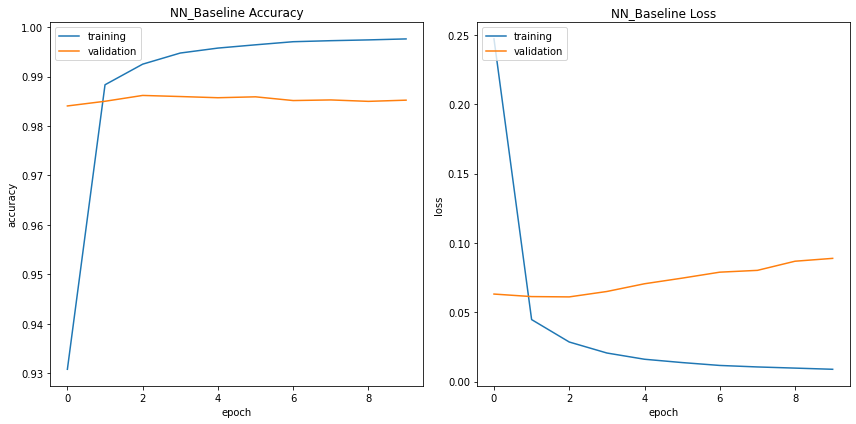

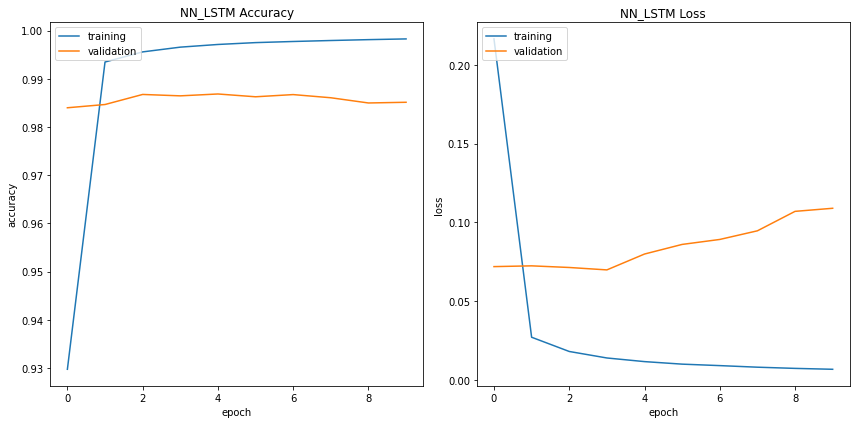

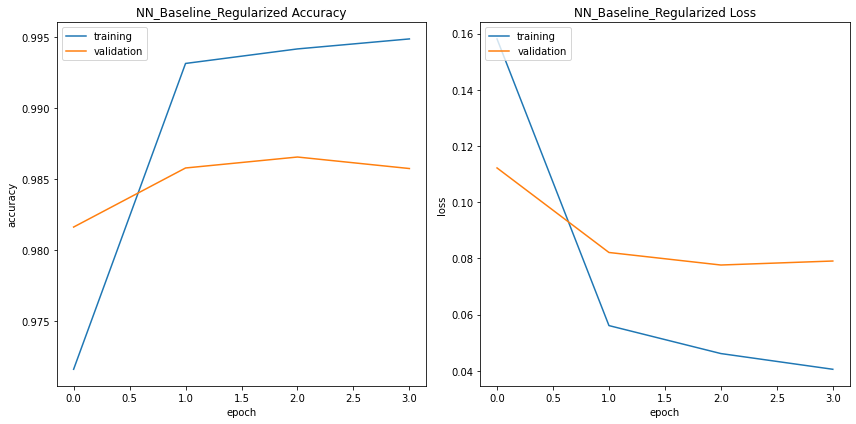

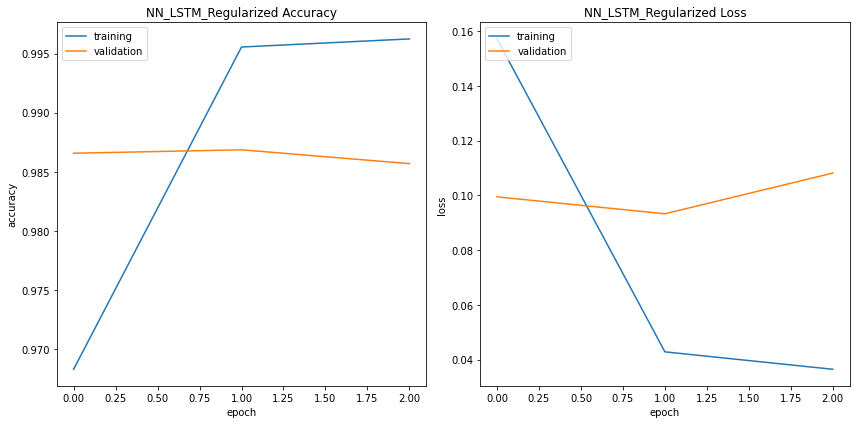

In [14]:
from scripts.metrics import plot_accuracy_and_loss

for name, train in training.items():
  plot_accuracy_and_loss(name, train)

Es posible observar en las gráficas que los modelos originales empiezan a experimentar *overfitting* de forma bastante prematura en su entrenamiento.
Incluso pareciera que su función de pérdida fuese creciente (cuando idealmente quisiéramos que fuera decreciente).

En cambio, para los modelos regularizados, se observa que su entrenamiento es bastante breve.
Tan pronto hay indicios de *overfitting*, se finaliza el entrenamiento y se retornan los pesos del modelo a la mejor configuración encontrada.

In [15]:
from scripts.metrics import show_balanced_accuracy

for name, model in models.items():
  show_balanced_accuracy(name, model, padded_sentences_test, encoded_labels_test, df_test)

NN_Baseline
Balanced Accuracy (General): 0.868309063693738
Balanced Accuracy (Reliable): 0.8653958049846823
Balanced Accuracy (Unreliable): 0.8686115515697246
NN_LSTM
Balanced Accuracy (General): 0.9836447196855701
Balanced Accuracy (Reliable): 0.9917904438397839
Balanced Accuracy (Unreliable): 0.9821935175409504
NN_Baseline_Regularized
Balanced Accuracy (General): 0.986818614208075
Balanced Accuracy (Reliable): 0.9937570141331481
Balanced Accuracy (Unreliable): 0.985600475550951
NN_LSTM_Regularized
Balanced Accuracy (General): 0.9871401527286825
Balanced Accuracy (Reliable): 0.994456788690079
Balanced Accuracy (Unreliable): 0.9858739272250835


Notar que los modelos regularizados superan en todas las métricas (al estudiar la *balanced accuracy*) a los modelos originales en los que están basados.
Probablemente sea causa de haber conservado la mejor configuración encontrada durante el entrenamiento de sus pesos.

A simple vista, el mejor modelo es `LSTM Regularized`.

In [16]:
data = []
for name, model in models.items():
  loss, accuracy = model.evaluate(padded_sentences_test, encoded_labels_test, verbose=0)
  data.append({'Model Name': name, 'Test Loss': loss, 'Test Accuracy': accuracy})

df = pd.DataFrame(data)

df

,Model Name,Test Loss,Test Accuracy
0,NN_Baseline,0.848265,0.867926
1,NN_LSTM,0.117211,0.983518
2,NN_Baseline_Regularized,0.079272,0.986788
3,NN_LSTM_Regularized,0.092656,0.987128


Y una vez más, se observa que los modelos regularizados superan a los modelos originales.

**Sección 3**
Ajuste de Hiperparámetros

En esta sección utilizaremos la librería `keras_tuner`, la cual nos ayudará a buscar los parámetros óptimos para nuestra red neuronal.
Construiremos un modelo con algunos elementos no definidos y será tarea del ajustador encontrar un conjunto de parámetros que maximicen la capacidad predictiva del mismo.

Notar que estaremos experimentando con la arquitectura de la red neuronal, y su respectiva tasa de aprendizaje.

In [17]:
from keras_tuner.tuners import RandomSearch

from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten
from keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import Adam

In [18]:
def NN_Builder(HP):
  """
  Definición de NN para la búsqueda de hiperparámetros.
  Intentamos encontrar...
  - #Neuronas en la Capa de LSTM
  - #Capas Densas
  - #Neuronas en cada Capa Densa
  - Activación de cada Capa Densa
  - Tasa de Aprendizaje
  """
  model = Sequential()
  # Entrada del Modelo
  model.add(embedding_layer)
  # Neuronas en Capa LSTM
  LSTM_units = HP.Int('LSTM_units', min_value=32, max_value=128, step=32)
  model.add(LSTM(LSTM_units))
  # Capas Densas
  Dense_layers = HP.Int('Dense_layers', min_value=1, max_value=5)
  for i in range(1, Dense_layers + 1):
    # Neuronas en Capa Densa
    Dense_units = HP.Int(f'Dense_units_{str(i)}', min_value=32, max_value=512, step=32)
    # Activación en Capa Densa
    Dense_activation = HP.Choice(f'Dense_activation_{str(i)}', ['sigmoid', 'relu'])
    model.add(Dense(Dense_units, activation=Dense_activation))
  # Salida del Modelo
  model.add(Flatten())
  model.add(Dense(len(classes), activation='softmax'))
  # Learning Rate
  Model_lr = HP.Choice('Model_lr', [1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
  # Compilamos el modelo definido
  model.compile(optimizer=Adam(Model_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

Ahora es necesario definir el espacio de búsqueda para nuestro ajustador.
Utilizaremos `RandomSearch` ya que el espacio es demasiado grande, y no contamos con el tiempo suficiente para realizar una búsqueda exhaustiva.

In [19]:
tuner = RandomSearch(NN_Builder,
                     objective='val_accuracy',
                     max_trials=50,
                     seed=123,
                     directory='MeLi_NeuralNetwork',
                     project_name='RandomSearch')

tuner.search_space_summary()

Search space summary
Default search space size: 5
LSTM_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
Dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
Dense_units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
Dense_activation_1 (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid', 'relu'], 'ordered': False}
Model_lr (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001, 1e-05], 'ordered': True}


A simple vista, pareciera que el espacio de búsqueda posee cinco dimensiones.
Hay que tener en cuenta que en realidad es mucho mayor, ya que por cada `Dense_layer` habrá otra elección de `Dense_units_i` y `Dense_activation_i`.

Vamos a realizar **50** intentos.

In [20]:
tuner.search(padded_sentences_train,
             encoded_labels_train,
             validation_split=0.2,
             epochs=1)

Trial 50 Complete [00h 03m 24s]
val_accuracy: 0.9840745329856873

Best val_accuracy So Far: 0.9874277710914612
Total elapsed time: 02h 32m 15s
INFO:tensorflow:Oracle triggered exit


**Sección 3**
Resultados de la Búsqueda

In [21]:
# Obtenemos los mejores hiperparámetros encontrados durante la búsqueda.
best_hyperparameters = tuner.get_best_hyperparameters()[0]

LSTM_units = best_hyperparameters.get('LSTM_units')
print(f'#Neuronas LSTM: {LSTM_units}')

Dense_layers = best_hyperparameters.get('Dense_layers')
print(f'#Capas Densas: {Dense_layers}')

for i in range(1, Dense_layers + 1):
  units = best_hyperparameters.get(f'Dense_units_{i}')
  activation = best_hyperparameters.get(f'Dense_activation_{i}')
  print(f'\t{i} | #Neuronas: {units} | Activación: {activation}')

Model_lr = best_hyperparameters.get('Model_lr')
print(f'Tasa de Aprendizaje: {Model_lr}')

#Neuronas LSTM: 64
#Capas Densas: 1
	1 | #Neuronas: 128 | Activación: relu
Tasa de Aprendizaje: 0.001


Parece que el mejor modelo encontrado es mucho más simple en comparación a los que estuvimos entrenando.

In [22]:
# Construyo el modelo con los mejores parámetros encontrados durante la búsqueda.
best_model = tuner.hypermodel.build(best_hyperparameters)
name = 'NN_Builder'

# Definimos un Early Stopping ya que parecen producir buenos resultados.
early_stop = EarlyStopping(monitor='val_accuracy',
                           mode='max',
                           restore_best_weights=True,
                           patience=1,
                           verbose=1)

# Realizamos un entrenamiento completo de nuestro mejor modelo encontrado.
print(f'{name}:')
history = best_model.fit(padded_sentences_train,
                         encoded_labels_train,
                         validation_split=0.2,
                         callbacks=[early_stop],
                         epochs=10,
                         verbose=1)

NN_Builder:
Epoch 1/10
12936/12936 [==============================] - 154s 12ms/step - loss: 0.0413 - accuracy: 0.9895 - val_loss: 0.0634 - val_accuracy: 0.9874
Epoch 2/10
12936/12936 [==============================] - 152s 12ms/step - loss: 0.0142 - accuracy: 0.9965 - val_loss: 0.0671 - val_accuracy: 0.9873
Restoring model weights from the end of the best epoch.
Epoch 00002: early stopping


Con el mejor modelo encontrado ya entrenado completamente, es hora de estudiar su desempeño a la hora de predecir.

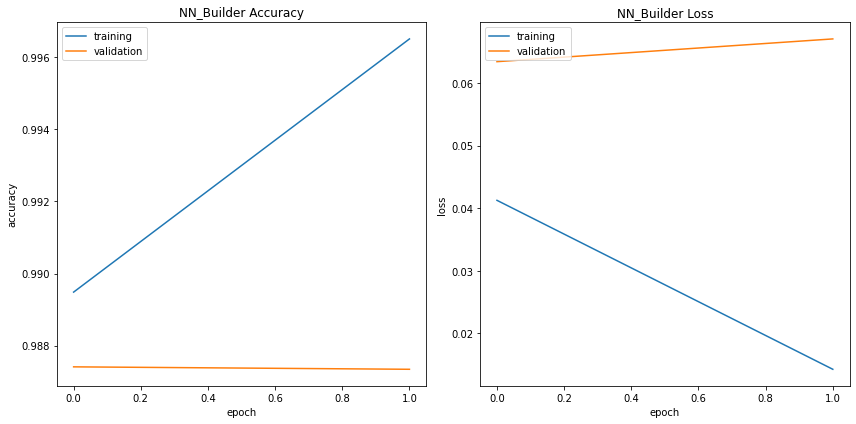

In [23]:
plot_accuracy_and_loss(name, history)

Claramente la gráfica no nos dice mucho, ya que la red neuronal solo entrenó por un par de *epochs*.

In [24]:
show_balanced_accuracy(name, best_model, padded_sentences_test, encoded_labels_test, df_test)

NN_Builder
Balanced Accuracy (General): 0.9872260182920065
Balanced Accuracy (Reliable): 0.994185890947449
Balanced Accuracy (Unreliable): 0.986055546373333


**Sección 4**
Documentación de Resultados

In [25]:
loss, accuracy = best_model.evaluate(padded_sentences_test, encoded_labels_test, verbose=0)

data = {'Model Name': name, 'Test Loss': loss, 'Test Accuracy': accuracy}

df = df.append(data, ignore_index=True)

df

,Model Name,Test Loss,Test Accuracy
0,NN_Baseline,0.848265,0.867926
1,NN_LSTM,0.117211,0.983518
2,NN_Baseline_Regularized,0.079272,0.986788
3,NN_LSTM_Regularized,0.092656,0.987128
4,NN_Builder,0.062401,0.987151


In [26]:
df.to_csv('Checkpoint/regularization_results.csv', header=True, index=False)

Finalizando, nuesto modelo elegido es `Builder`.
Por un margen pequeño resultó ser la red neuronal con mejores resultados durante la experimentación.
Incluso se podría decir que es el modelo más simple utilizado durante el laboratorio.

In [27]:
chosen_model = best_model

In [28]:
from sklearn.metrics import classification_report

probabilities = chosen_model.predict(padded_sentences_test, verbose=0)
predictions = np.argmax(probabilities, axis=-1)

print(classification_report(encoded_labels_test, predictions, target_names=classes))

                    precision    recall  f1-score   support

    BABY_CAR_SEATS       0.98      0.98      0.98      6709
    BABY_STROLLERS       0.97      0.98      0.98      6219
     COFFEE_MAKERS       0.99      0.99      0.99      6968
   ELECTRIC_DRILLS       1.00      0.99      0.99      6304
     HAIR_CLIPPERS       0.99      0.99      0.99      6421
     KITCHEN_SINKS       0.99      0.99      0.99      6242
        MATTRESSES       0.99      0.99      0.99      6546
      MEMORY_CARDS       0.99      0.98      0.99      6139
MOTORCYCLE_JACKETS       1.00      0.99      0.99      6500
 MUSICAL_KEYBOARDS       0.99      0.99      0.99      6671
             PANTS       0.99      0.97      0.98      7225
     PUREBRED_DOGS       0.97      0.99      0.98      6606
            RANGES       0.99      0.99      0.99      6553
     REFRIGERATORS       0.99      0.99      0.99      6469
     ROLLER_SKATES       0.98      0.99      0.99      6329
   SEWING_MACHINES       0.99      0.99

In [29]:
test_title = df_test.title
test_prediction = le.inverse_transform(predictions)

submission = pd.DataFrame(list(zip(test_title, test_prediction)), columns=['title', 'category'])
submission.to_csv('DataSet/regularization_submission.csv', header=True, index=False)

## 3. Conclusiones

A lo largo del notebook se han realizado comentarios sobre los resultados obtenidos.
Por lo cual no hay demasiado para agregar en esta parte del reporte.
De todas formas podríamos listar algunos trabajos futuros para complementar el estudio realizado.

- No hemos experimentado modificando el `batch_size`. Quizás otro factor determinante en la capacidad de predicción de un modelo sea este hiperparámetro. Deberíamos estudiar como varía el desempeño en base al tamaño del lote empleado durante el entrenamiento de la red neuronal.

- Utilizar *early stopping* sirvió para obtener resultados excelentes. Un aspecto que no se estudió debidamente fue aumentar la paciencia en el entrenamiento, lo cual extendería el entrenamiento de la red neuronal pero aumentaría la posibilidad de hallar un mínimo local mejor al encontrado.

- Sería posible expandir el espacio de búsqueda del ajustador agregando otros factores variables a la arquitectura de la red, como también de sus hiperparámetros. No se consideraron capas `Dropout` ni `BatchNormalization`, y tampoco se intentó agregar términos de regularización `l2`.